In [3]:
#classifierで1時間軸で予測をおこなう
#いろいろな特徴量を試す

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xgboost
import sys
sys.path.append("./skynet/bf/src/scripts/")
import xgboost_ohlc
import utils
import numpy as np
import seaborn as sns
import talib
import datetime
import random
import requests
import time
import itertools
%matplotlib inline

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
pd.options.display.precision = 10

In [60]:
version = '2101'
data_size = 10000
ds_li = [6000,10000,25000,50000,100000]
ds_li = [6000]
test = 0.2
test_size = data_size*test
test_size = 1000

features = ['MACDS/O','RSI','C/O','H/O','L/O','Time','ATR/O','MACDL/O','H-L/O','O-2/C','O-1/C','H-1/C','L-1/C','MACDM/O']

In [52]:
result = 0
hour = pd.read_csv('skynet/bf/data/processed/hour.csv')
for data_size in ds_li:
    product = list(itertools.product([1,0],repeat=len(features)))
    random.shuffle(product)
    for v in product:
        data_columns = []
        for i,x in enumerate(v):
            if x == 1:
                data_columns.append(features[i])
        target_column = 'Target_UP'
        backtest_columns = ['timestamp','Target_Close','Target_Open','Close','Open']

        hour_for_ml = hour[data_columns+[target_column]+backtest_columns].dropna()
        train = hour_for_ml[-data_size:-test_size]
        test = hour_for_ml[-test_size:]
        backtest = hour_for_ml[-test_size:]
        all_data = hour_for_ml[-data_size:]

        data_train = train[data_columns]
        data_test = test[data_columns]


        target_train = train[target_column]
        target_test = test[target_column]


        xgbc = xgboost_ohlc.c_fit(data_train, target_train)

        predict = xgbc.predict(data_test)
        tmp = (predict == target_test).mean()
        print("*****")
        if tmp > result:
            result = tmp
            result_columns = data_columns
            result_ds = data_size
            print("tmp best ↓")
        print(tmp)
        print(data_columns)
        print(data_size)
        print("*****")
        
        time.sleep(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [69]:
0.556
data_columns = ['Time', 'MACDL/O', 'L-1/C']
0.561 #0.526
data_columns = ['MACDS/O', 'RSI', 'C/O', 'H/O', 'Time', 'ATR/O', 'MACDL/O', 'O-1/C', 'L-1/C']
0.559#0.543
data_columns = ['MACDS/O', 'RSI', 'L/O', 'Time', 'MACDL/O']
0.559 #0.559
data_columns = ['Time','MACDM/O']
0.557 #0.527
data_columns = ['L/O', 'Time', 'MACDL/O', 'O-2/C', 'L-1/C']
0.563 #0.54
data_columns = ['RSI','Time','MACDL/O','O-1/C']
0.53 #0.551
data_columns = ['RSI','Time','MACDS/O','O-1/C']
0.542 # 0.539
data_columns = ['RSI','Time','MACDM/O','O-1/C']
0.55 #0.537
data_columns = ['RSI','Time','MACDM/O']

data_columns = ['Time','MACDM/O']
data_columns = ['MACDS/O', 'RSI', 'C/O', 'Time', 'MACDL/O']

data_columns_list = [
    ['Time','MACDM/O'],
    ['RSI','Time','MACDL/O','O-1/C'],
    ['MACDS/O', 'RSI', 'L/O', 'Time', 'MACDL/O'],
    ['MACDS/O', 'RSI', 'C/O', 'H/O', 'Time', 'ATR/O', 'MACDL/O', 'O-1/C', 'L-1/C'],
    ['RSI','Time','MACDS/O','O-1/C'],
    ['RSI','Time','MACDM/O']
]

In [87]:
predicts = []
for i,data_columns in enumerate(data_columns_list):
    hour = pd.read_csv('skynet/bf/data/processed/hour.csv')
    target_column = 'Target_UP'
    backtest_columns = ['timestamp','Target_Close','Target_Open','Close','Open']

    hour_for_ml = hour[data_columns+[target_column]+backtest_columns].dropna()
    train = hour_for_ml[-data_size:-test_size]
    test = hour_for_ml[-test_size:]
    backtest = hour_for_ml[-test_size:]
    all_data = hour_for_ml[-data_size:]

    data_train = train[data_columns]
    data_test = test[data_columns]


    target_train = train[target_column]
    target_test = test[target_column]


    xgbc = xgboost_ohlc.c_fit(data_train, target_train)

    predict = xgbc.predict(data_test)
    predicts.append(predict)
    result = (predict == target_test)
    print(result.mean())

    xgbc_all_data = xgboost_ohlc.c_fit(all_data[data_columns],all_data[target_column])
    #xgbc_all_data = xgbc
    train.to_csv("skynet/bf/model/T_"+version+"/train.csv")
    test.to_csv("skynet/bf/model/T_"+version+"/test.csv")
    backtest.to_csv("skynet/bf/model/T_"+version+"/backtest.csv")
    pickle.dump(xgbc_all_data, open("skynet/bf/model/T_"+version+"/xgbr"+str(i+1)+".pickle", "wb"))
    with open("skynet/bf/model/T_"+version+"/spec."+str(i+1)+"txt", mode="w") as txt:
        txt.write(str(datetime.datetime.now())+'\n')
        txt.write('data_columns: '+str(data_columns)+"\n")
        txt.write('target_column: '+str(target_column)+"\n")
        txt.write('simplescore: '+str(result.mean())+"\n")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   16.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.559
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   18.7s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   19.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.546
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   21.8s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   23.0s finished


0.543
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   31.4s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   51.2s finished


0.526
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   33.4s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   20.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.551
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   23.0s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   20.7s finished


0.537
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   21.7s finished


In [83]:
p = predicts[0]+predicts[1]+predicts[2]+predicts[4]+predicts[5]

In [77]:
p =(p  > 0)*2-1

In [79]:
p

array([-1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1, -1, -1, -1, -1,  1,
       -1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1, -1,
       -1,  1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,
        1,  1,  1, -1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1,
        1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,
        1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1, -1,  1,
       -1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1

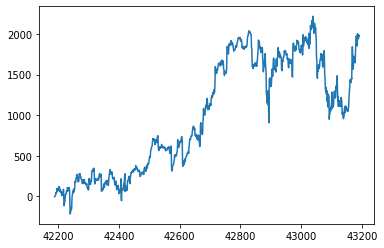

In [9]:
#5000
plt.plot((0.01*(predict)*(backtest['Target_Close']-backtest['Target_Open'])-1).cumsum())

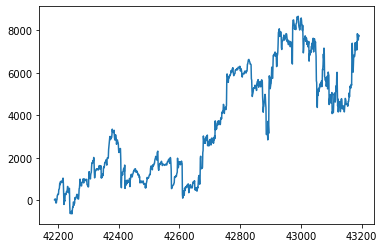

In [84]:
#10000
plt.plot((0.01*(p)*(backtest['Target_Close']-backtest['Target_Open'])-1).cumsum())

In [52]:
#########################################
#########################################
#########################################